<a href="https://colab.research.google.com/github/stefanogiagu/PHDMIB_2025/blob/main/notebooks/CNN_Ising2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional NN trained to recognize phases of a 2D Ising Model


In [1]:
# downlad example of configurations of ising2D
!rm -rf ising_conf.dat.gz
!rm -rf ising_conf.dat
!rm -rf ising_label.dat.gz
!rm -rf ising_label.dat
!wget http://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/ising_label.dat.gz
!gunzip ising_conf.dat.gz
!gunzip ising_label.dat.gz

--2025-06-18 12:12:27--  http://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.5.88, 188.185.50.104, 188.185.18.46, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.5.88|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz [following]
--2025-06-18 12:12:28--  https://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.5.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2953855 (2.8M) [application/x-gzip]
Saving to: ‘ising_conf.dat.gz’

ising_conf.dat.gz   100%[===================>]   2.82M  2.73MB/s    in 1.0s    

2025-06-18 12:12:29 (2.73 MB/s) - ‘ising_conf.dat.gz’ saved [2953855/2953855]

--2025-06-18 12:12:30--  http://giagu.web.cern.ch/giagu/CERN/ising_label.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 188.185.18.46, 18

### Basic Information on the 2D Ising Model ###

Details (theoretical definition and simulation) are provided in the [note](https://vixra.org/pdf/1710.0021v2.pdf).

The system consists of a set of spins (which can only take the values -1 (down) and +1 (up)) interacting with each other, located at the vertices of a two-dimensional square lattice. The dynamics of the system (in the absence of an external magnetic field) is described by the Hamiltonian:

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice indices $i,j$ refer to nearest neighbors on a 2D square lattice of side length $L$, and $J$ is an arbitrary scale parameter that defines the interaction energy between the spins $S_i$. Periodic boundary conditions are used on the lattice.

It can be shown that this system exhibits a phase transition in the thermodynamic limit, from an ordered state where all spins are aligned (an ordered ferromagnet) at zero temperature, to a disordered phase with completely random spins at high temperature. The critical temperature at which the transition occurs is given by:

$$T_c/J=1/\log(1+\sqrt{2})\approx 2.26$$.


**Dataset:**

A dataset of 25,000 configurations is provided, with $T/J$ uniformly distributed in the range $[0,5]$, for a 2D Ising model on a $28\times 28$ lattice, simulated using a simple Metropolis-type Monte Carlo method.

The dataset is available in two files:
* configurations: *ising_conf.dat*
* labels: *ising_label.dat*

Note: the configurations are stored in text files, which, when read with NumPy (*np.loadtxt*), return tensors of shape *(25000×28, 28)*. These need to be reshaped into format *(25000, 1, 28, 28)* to be used with convolutional layers in pytorch.

**Part 1:**

Loading, and pre-procesing of the dataset:L

1.   read the configurations and save it in a numpy tensor *data(25000,28,28)*, using the method *np.loadtxt* of numpy. Same for the tempartures: *temp(25000,1)*
2.   we divide the samples in three categories depending on the temeparture:
* ordered: $T<2.0$
* critical: $2.0\leq T\leq 2.5$
* disordered: $T>2.5$

  building a new numpy array of labels *(0,1,2)* associated to each configuration on *data*.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

rnd_ini = 123456
np.random.seed(rnd_ini) # shuffle random seed generator

# Ising model parameters
L=28 # latice size
J=1.0 # Ising interaction (1 ferromagnetic, -1 anti-ferromagnetic)
T_c=2.26 # critical temperature

#read the configurations from the text file (25k esempi oguno da 28x28 spin)
data = np.loadtxt('ising_conf.dat')
data = data.reshape(25000,28,28)
print('data shape: ',data.shape)

#read the associated temperature:
temp = np.loadtxt('ising_label.dat')
print('temp shape: ',temp.shape)

data shape:  (25000, 28, 28)
temp shape:  (25000,)


Compute and plot the distribution of the average magnetization of the configurations:

$$M = \frac{1}{N}\sum_i^N S_i$$

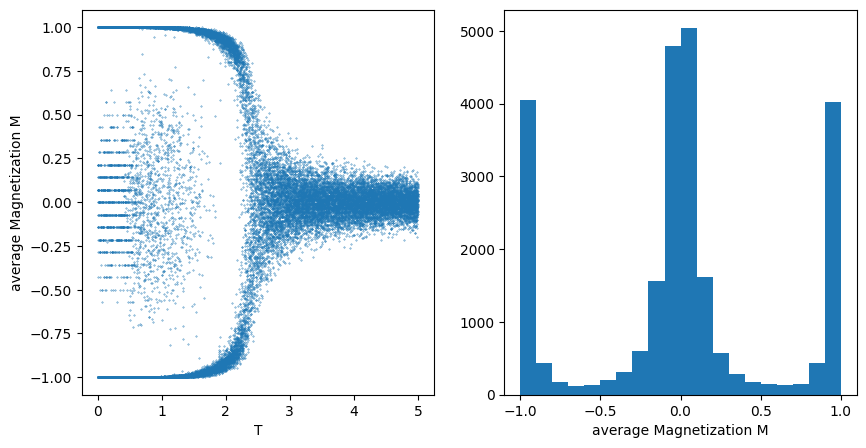

In [4]:
M = np.sum(data.reshape(25000,28*28), axis=1)/(28*28)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(temp, M, s=0.1)
plt.xlabel('T')
plt.ylabel('average Magnetization M')
plt.subplot(1,2,2)
plt.hist(M, bins=20)
plt.xlabel('average Magnetization M')
plt.draw()

In [5]:
# divide the data in 3 groups on the base of the phase state (ordered, critical disordered)
# T/J < 2.0 ordered
# T/J in [2.0,2.5] critical
# T/J > 2.5 disordered

ord_sele = (temp < 2.0)
cri_sele = ((temp >= 2.0) & (temp <= 2.5))
dis_sele = (temp > 2.5)

labels = np.zeros(shape=temp.shape)
labels[ord_sele]=0
labels[cri_sele]=1
labels[dis_sele]=2

print('labels shape: ',labels.shape)
print('# conf. ordered: ', labels[ord_sele].shape[0])
print('# conf. critical: ', labels[cri_sele].shape[0])
print('# conf. disordered: ', labels[dis_sele].shape[0])

labels shape:  (25000,)
# conf. ordered:  9953
# conf. critical:  2563
# conf. disordered:  12484


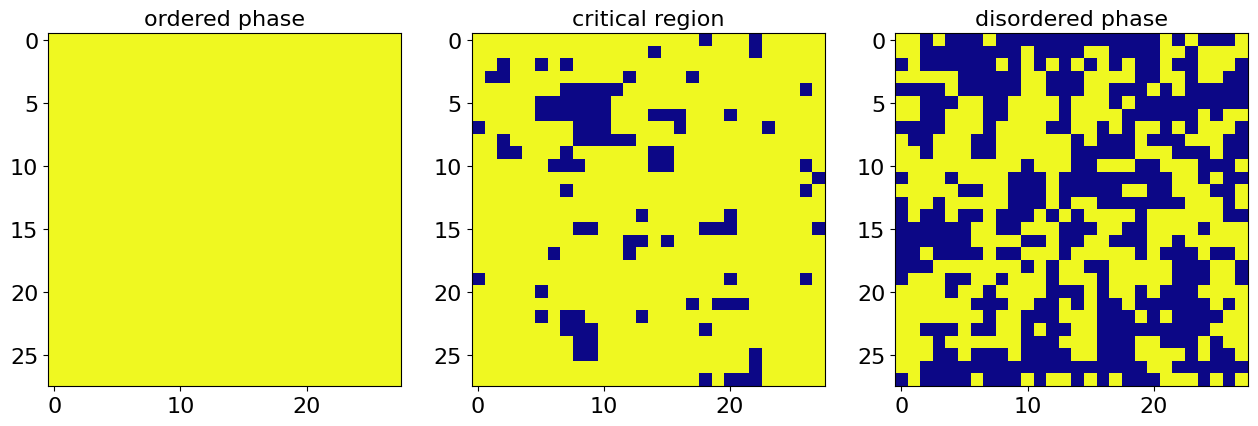

In [6]:
# plot an example of each group

# set colorbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

ieve = 11
axarr[0].imshow((data[ord_sele])[ieve],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow((data[cri_sele])[ieve],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow((data[dis_sele])[ieve],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

**Part 2**:

Implement and train a Convolutional-NN for the 3-classes classification task

In [7]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [8]:
if torch.cuda.is_available():
  print('Number of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# sif GPU available set device to 'cuda' otherwise to 'cpu'
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Number of available GPUs:  1
Tesla T4
Computation device: cuda



In [9]:
# CNN expect shape of input images like: (B, Channels, hdim, vdim), in our case (B, 1, 28, 28)
# we need to add a dummy dimension to the vectors

data = data.reshape(25000,28,28,1)


# convert data, temp and labels in torch tensors
data_tensor = torch.from_numpy(data).type(torch.float32)
# move last index as second index
data_tensor = data_tensor.permute(0,3,1,2)

temp_tensor = torch.from_numpy(temp).type(torch.float32)
labels_tensor = torch.from_numpy(labels).type(torch.long)

print(data_tensor.shape)
print(temp_tensor.shape)
print(labels_tensor.shape)

# create datasets
dataset = torch.utils.data.TensorDataset(data_tensor, labels_tensor, temp_tensor)

# split dataset in training, validation and test

ds_train, ds_vali, ds_test = torch.utils.data.random_split(dataset, [0.7,0.2,0.1])


print('Trainign set size: ', len(ds_train))
print('Validation set size: ',len(ds_vali))
print('Test set size: ',len(ds_test))

# create dataloader
batch_size = 128
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
dl_vali = torch.utils.data.DataLoader(ds_vali, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=True, num_workers=2)

torch.Size([25000, 1, 28, 28])
torch.Size([25000])
torch.Size([25000])
Trainign set size:  17500
Validation set size:  5000
Test set size:  2500


In [10]:
# Convolutional Neural Network (VGG-like architecture)

from torch import nn
import torch.nn.functional as F

class myVGG(nn.Module):
  def __init__(self):
    super(myVGG, self).__init__()

    # first convolutional block
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3))
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

    # secondo convolutional block
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3))
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    # classification head (MLP)
    self.flatten = nn.Flatten() #flatten layer
    self.drop1 = nn.Dropout(p=0.5) #droput
    self.fc1 = nn.Linear(in_features=400, out_features=32)
    self.drop2 = nn.Dropout(p=0.5) #dropout
    self.fc2 = nn.Linear(in_features=32, out_features=32)
    self.fc3 = nn.Linear(in_features=32, out_features=3)

  # forward pass: x (input) -> out
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    #flatten
    x = self.flatten(x)

    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))

    out = self.fc3(x) #no softmax needed as already applied in the CrossEntropyLoss in pytorch
    return out

In [10]:
# printout of the model

model = myVGG()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,28,28))
else:
  summary(model, input_size=(1,28,28))

myVGG(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
         MaxPool2d-2            [-1, 8, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]           1,168
         MaxPool2d-4             [-1, 16, 5, 5]    

In [11]:
# test di un batch sul modello non addestrato per vedere che le cose funzionino

model = myVGG()
model.to(device)

feat, label, temp = next(iter(dl_train))

feat=feat.to(device)
label=label.to(device)

out = model(feat)

print(out.shape)
print(out[0])

torch.Size([128, 3])
tensor([-0.0048,  0.0257, -0.0464], device='cuda:0', grad_fn=<SelectBackward0>)


In [12]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [11]:
# loss function, accuracy, optimzer

# loss function
loss_func = nn.CrossEntropyLoss() #cross entropy loss

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=3)
metric_fun = metric_fun.to(device)

# Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

# add a LR scheduler (decrese LR of a factor gamma every 15 epochs): lr = lr*gamma
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)

In [12]:
# Training function
import time

def train_model(nn_model, criterion, metric, n_epochs, dl_train, dl_vali):

  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []

  best_valid_loss=float('inf') #initialize checkpoint counter


  # loop over epochs
  for epoch in range(n_epochs):
    t0 = time.time()

    # training phase
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0
    for xb, yb, _ in dl_train:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb)


        loss = criterion(pred, yb)
        if metric != None:
          tmetric = metric(pred, yb)

        train_loss += loss.item()
        if metric != None:
          train_metric += tmetric.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    if metric != None:
      train_metric /= counter
      hist_metric.append(train_metric)


    # validation phase
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad():
      for xb, yb, _ in dl_vali:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb)

        vloss = criterion(pred, yb)
        vali_loss += vloss.item()

        if metric != None:
          vmetric = metric(pred, yb)
          vali_metric += vmetric.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    if metric != None:
      vali_metric /= counter
      hist_vmetric.append(vali_metric)


    elapsed_time = time.time()-t0
    if metric != None:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f"
            % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    else:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, vali loss: %.6f"
            % (epoch+1, elapsed_time, train_loss, vali_loss))


    #save best model
    if vali_loss < best_valid_loss:
      best_valid_loss = vali_loss
      print(f"\nBest validation loss: {best_valid_loss}")
      print(f"\nSaving best model for epoch: {epoch+1}\n")
      torch.save(model.state_dict(), 'best_model_w.pth')


    # update learning rate schedule
    scheduler.step()

  return nn_model, hist_loss, hist_metric, hist_vloss, hist_vmetric

In [14]:
# Training

model = myVGG()
model.to(device)
opt = optim.Adam(model.parameters(), lr=LR_ST)
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)
metric_fun = metric_fun.to(device)

# numero di epoche
epochs = 40

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dl_train, dl_vali=dl_vali)


epoch: 1, time(s): 1.9507, train loss: 0.433413, train metric: 0.827148, vali loss: 0.117246, vali metric: 0.950721

Best validation loss: 0.1172460390207095

Saving best model for epoch: 1

epoch: 2, time(s): 1.2950, train loss: 0.151843, train metric: 0.943302, vali loss: 0.097378, vali metric: 0.961538

Best validation loss: 0.09737807235274559

Saving best model for epoch: 2

epoch: 3, time(s): 1.3807, train loss: 0.131624, train metric: 0.950712, vali loss: 0.091863, vali metric: 0.964143

Best validation loss: 0.09186312422538415

Saving best model for epoch: 3

epoch: 4, time(s): 1.4389, train loss: 0.124486, train metric: 0.951057, vali loss: 0.111470, vali metric: 0.953526
epoch: 5, time(s): 2.1277, train loss: 0.115810, train metric: 0.953355, vali loss: 0.087057, vali metric: 0.961939

Best validation loss: 0.08705701898687924

Saving best model for epoch: 5

epoch: 6, time(s): 1.3807, train loss: 0.117900, train metric: 0.951919, vali loss: 0.106428, vali metric: 0.955329
e

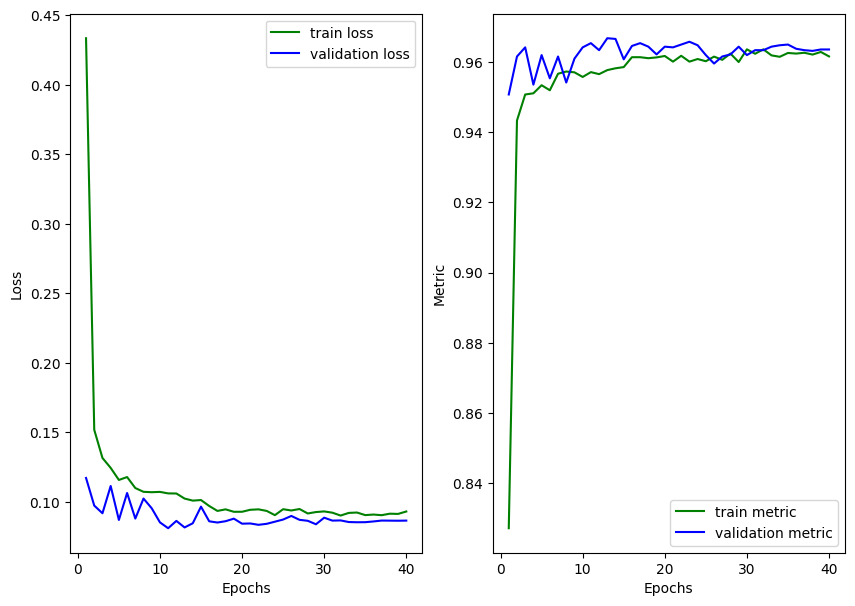

In [15]:
# draw training curves
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [16]:
# load the best model weights
checkpoint = torch.load('./best_model_w.pth')
model = myVGG()
model.load_state_dict(checkpoint)
model.eval()

myVGG(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

In [17]:
# test set perfromance

model.to(torch.device('cpu'))
metric_fun = metric_fun.to('cpu')

loss = 0
metric = 0
counter = 0

for xb, yb,_ in dl_test:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_fun(pred, yb).item()


loss /= counter
metric /= counter

print('Test loss/accuracy: ',loss, ' / ', metric)

Test loss/accuracy:  0.0829729347698225  /  0.9672


In [18]:
#confusion matrix

#nice printout
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))

for xb, yb, _ in dl_test:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")
labels = ['0','1','2']
print_cm(c_mat, labels)

Confusion Matrix:
              0     1     2 
        0  0.98  0.02  0.00 
        1  0.09  0.83  0.08 
        2  0.00  0.02  0.98 


**Part 3:**

Transfer Learning: let's get a pretrained CNN model and fine tune it for our task ...

In [13]:
# let's take a pretrained model from torchvision repository

from torchvision import datasets, transforms, models

# example VGG11
model = models.vgg11(pretrained= True)

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [19]:
# freeze

for param in model.parameters():
    param.requires_grad = False

# classification Head

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('dropout1',nn.Dropout(0.5)),
    # define the inputs
    ('fc1',nn.Linear(25088,64)),
    ('relu1', nn.ReLU()),
    ('dropout2',nn.Dropout(0.5)),
    ('fc2',nn.Linear(64,64)),
    ('relu2', nn.ReLU()),
    ('output',nn.Linear(64,3)),
    #('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [20]:
# loss e optmizer

loss_func = nn.CrossEntropyLoss() #cross entropy loss

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=3)
metric_fun = metric_fun.to(device)

# optimizer
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

In [16]:
# NOTE: we need to transform our dataset to match the requirements of the pretrained model. In this case:

# image shape: (3,224,244) <-- we have (1,28,28), so we need to resize to 224x224 and then stack three times the same channel

data = data.reshape(25000,28,28)

# convert data, temp and labels in torch tensors
data_tensor = torch.from_numpy(data).type(torch.float32)

from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize((224, 224))
])

data_tensor_3 = transform(data_tensor)
print(data_tensor_3.shape)

data_tensor_3 = torch.stack((data_tensor_3, data_tensor_3, data_tensor_3), dim=-1)
data_tensor_3 = data_tensor_3.permute(0,3,1,2)

print(data_tensor_3.shape)



torch.Size([25000, 224, 224])
torch.Size([25000, 3, 224, 224])


In [17]:
#create datasets
dataset = torch.utils.data.TensorDataset(data_tensor_3, labels_tensor, temp_tensor)

# split dataset in training, validation and test
ds_train, ds_vali, ds_test = torch.utils.data.random_split(dataset, [0.7,0.2,0.1])


print('Trainign set size: ', len(ds_train))
print('Validation set size: ',len(ds_vali))
print('Test set size: ',len(ds_test))

# create dataloader
batch_size = 128
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
dl_vali = torch.utils.data.DataLoader(ds_vali, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=True, num_workers=2)

Trainign set size:  17500
Validation set size:  5000
Test set size:  2500


In [ ]:
# Training

model.to(device)

epochs = 20
model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dl_train, dl_vali=dl_vali)

epoch: 1, time(s): 56.3766, train loss: 0.132361, train metric: 0.952206, vali loss: 0.080169, vali metric: 0.966146

Best validation loss: 0.08016875453102283

Saving best model for epoch: 1



In [ ]:
# fine tuning:
for param in model.parameters():
    param.requires_grad = True

LR_ST = 1e-6
opt = optim.Adam(model.parameters(), lr=LR_ST)


epochs = 5
model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dl_train, dl_vali=dl_vali)